In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

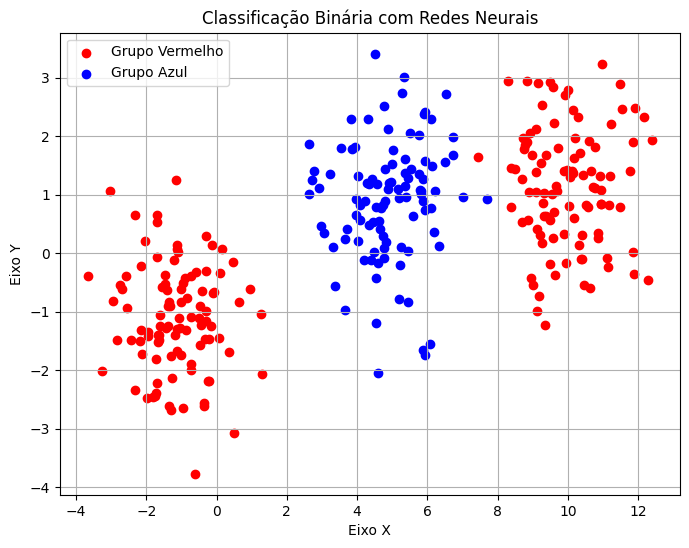

In [2]:
# Definindo os centros dos grupos
centro_azul = [10, 1]
centro_vermelho = [-1, -1]
centro_vermelho_2 = [5,1]

# Gerando pontos aleatórios em torno dos centros
np.random.seed(0)
pontos_azuis = np.random.randn(100, 2) + centro_azul
pontos_vermelhos = np.random.randn(100, 2) + centro_vermelho
pontos_vermelhos_2 = np.random.randn(100,2) + centro_vermelho_2

# Plotando os pontos
plt.figure(figsize=(8, 6))
plt.scatter(pontos_azuis[:, 0], pontos_azuis[:, 1], color='red')
plt.scatter(pontos_vermelhos[:, 0], pontos_vermelhos[:, 1], color='red', label='Grupo Vermelho')
plt.scatter(pontos_vermelhos_2[:, 0], pontos_vermelhos_2[:, 1], color='blue', label='Grupo Azul')
plt.title("Classificação Binária com Redes Neurais")
plt.xlabel("Eixo X")
plt.ylabel("Eixo Y")
plt.legend()
plt.grid(True)
plt.show()


In [3]:
# Preparar os Dados
# Combina os conjuntos de pontos com os azuis no meio
X = np.vstack((pontos_vermelhos, pontos_azuis, pontos_vermelhos_2))
Y = np.array([0]*100 + [0]*100 + [1]*100)  # 1 para pontos azuis, 0 para pontos vermelhos

# Redimensionando Y para corresponder às dimensões esperadas pela rede neural
Y = Y.reshape(1, -1)

# Verificando as dimensões
# X possui 200 exemplos de treinamento (100 azuis e 100 vermelhos) e cada exemplo tem 2 características
print("Dimensões de X:", X.shape)
print("Dimensões de Y:", Y.shape) # Y bem definido, não é rank 1 array (,200)


Dimensões de X: (300, 2)
Dimensões de Y: (1, 300)


In [4]:
X = X.T  # Transpõe a matriz
print("Dimensões (n[0],m) de X:", X.shape) # X deve ter dimensão (n[0],m)
# n[0] é o número de características ou número de linhas
# e o número de exemplos de treinamento (m) é o número de colunas

Dimensões (n[0],m) de X: (2, 300)


In [5]:
def inicializacao(input_size,hidden_size,output_size):
    w1 = np.random.randn(hidden_size, input_size) * 0.01
    b1 = np.zeros((hidden_size,1))

    w2 = np.random.randn(output_size,hidden_size) * 0.01
    b2 = np.zeros((output_size,1))

    assert(w1.shape == (hidden_size, input_size))
    assert(b1.shape == (hidden_size,1))
    assert(w2.shape == (output_size,hidden_size))
    assert(b2.shape == (output_size,1))

    parametros = {  'w1' : w1,
                    'b1' : b1,
                    'w2' : w2,
                    'b2' : b2
                }

    return parametros

In [6]:
def relu(z):
    return np.maximum(0,z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def forward(X,parametros):

    w1 = parametros["w1"]
    b1 = parametros["b1"]
    w2 = parametros["w2"]
    b2 = parametros["b2"]

    # a ordem do np.dot tem que ser sempre w1 depois X como na fórmula
    z1 = np.dot(w1,X) + b1
    a1 = relu(z1)
    z2 = np.dot(w2,a1) + b2
    a2 = sigmoid(z2)

    foward_parametros = { 'z1': z1,
                          'a1': a1,
                          'z2': z2,
                          'a2': a2
                        }
    return foward_parametros

In [7]:
def relu_derivative(z):
    return np.where(z >= 0, 1, 0)

def loss(a2, Y):
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(a2) + (1 - Y) * np.log(1 - a2)) / m
    cost = np.squeeze(cost)
    return cost


def grad(x, y,parametros,foward_parametros ):

        w1 = parametros["w1"]
        w2 = parametros["w2"]

        z1 = foward_parametros['z1']
        z2 = foward_parametros['z2']
        a1 = foward_parametros['a1']
        a2 = foward_parametros['a2']

        # Retropropagação

        delta2 = a2 - y #dz[2(camada2,saída)]

        # keepdims previne rank1 arrays
        grad_w2 = (1/x.shape[1]) * np.dot(delta2,a1.T) #dw[2]

        grad_b2 = (1/x.shape[1]) * np.sum(delta2, axis=1, keepdims=True) #db[2]

        delta1 = np.dot(w2.T,delta2) * relu_derivative(z1) #dz[1]

        grad_w1 = (1/x.shape[1]) * np.dot(delta1,x.T) #dw[1]

        grad_b1 = (1/x.shape[1]) * np.sum(delta1, axis=1, keepdims=True) #db[1]

        grads = { 'dw1' : grad_w1,
                  'db1' : grad_b1,
                  'dw2' : grad_w2,
                  'db2' : grad_b2
        }

        return grads

In [8]:
def atualizar(parametros,grads,learning_rate= 0.01, num_epochs = 10):
    w1 = parametros['w1']
    b1 = parametros['b1']
    w2 = parametros['w2']
    b2 = parametros['b2']

    dw1 = grads['dw1']
    db1 = grads['db1']
    dw2 = grads['dw2']
    db2 = grads['db2']

    w1 = w1 - learning_rate*dw1
    b1 = b1 - learning_rate*db1
    w2 = w2 - learning_rate*dw2
    b2 = b2 - learning_rate*db2

    parametros = {"w1": w1,
                  "b1": b1,
                  "w2": w2,
                  "b2": b2}

    return parametros


In [12]:
# Função para treinar o modelo
def treinar_modelo(X, Y, hidden_size,num_iterations=1000, learning_rate=0.01):

    input_size = X.shape[0]
    output_size = 1

    parametros = inicializacao(input_size, hidden_size, output_size)

    for i in range(0, num_iterations):

        # Propagação para frente
        foward_parametros = forward(X, parametros)
        a2 = foward_parametros['a2']

        # Cálculo do erro
        erro = loss(a2, Y)

        # Retropropagação
        grads = grad(X, Y, parametros, foward_parametros)

        # Atualizar parâmetros
        parametros = atualizar(parametros, grads, learning_rate)


    print("erro após iterações: %f" %erro)

    return parametros

In [10]:
def prever(X, parametros):
    # Calcula a propagação para frente
    forward_params = forward(X, parametros)
    a2 = forward_params['a2']

    # Aplica um limiar para obter previsões binárias
    previsoes = (a2 > 0.5).astype(int)
    return previsoes

erro após iterações: 0.228475


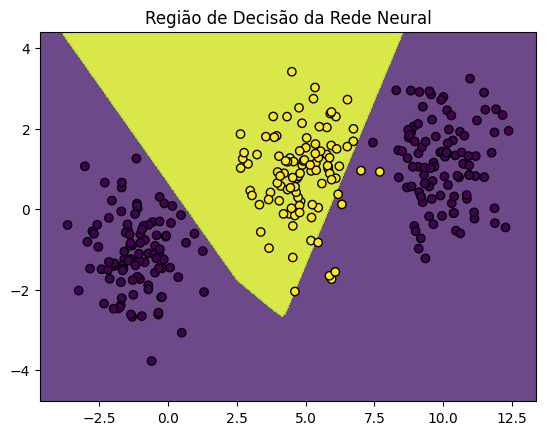

In [13]:
# Criar uma grade de pontos
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

parametros = treinar_modelo(X, Y, 10, num_iterations=4000)

# Prever a classe para cada ponto na grade
grid = np.c_[xx.ravel(), yy.ravel()].T
Z = prever(grid, parametros)
Z = Z.reshape(xx.shape)

# Plotar a região de decisão
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Região de Decisão da Rede Neural")
plt.show()

In [17]:
def busca_hiperparametros(X, Y, hidden_sizes, learning_rates, num_iterations_list):
    best_error = float('inf')
    best_lr = None
    best_iters = None
    best_hidden_size = None
    best_params = None

    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            for iters in num_iterations_list:
                print(f"Treinando com hidden_size = {hidden_size}, learning rate = {lr}, e num_iterations = {iters}")
                parametros = treinar_modelo(X, Y, hidden_size, num_iterations=iters, learning_rate=lr)
                forward_params = forward(X, parametros)
                erro_atual = loss(forward_params['a2'], Y)

                if erro_atual < best_error:
                    best_error = erro_atual
                    best_lr = lr
                    best_iters = iters
                    best_hidden_size = hidden_size
                    best_params = parametros

                print(f"Erro: {erro_atual} com Hidden Size: {hidden_size}, LR: {lr}, e Iterações: {iters}")

    print(f"Melhor erro: {best_error} com Hidden Size: {best_hidden_size}, Learning Rate: {best_lr}, e Número de Iterações: {best_iters}")
    return best_params, best_hidden_size, best_lr, best_iters

In [20]:
hidden_size_list = [10,50,100]

learning_rates = [0.01, 0.001, 0.0001]
num_iterations_list = [1000, 5000, 10000]

best_params, best_hidden_size, best_lr, best_iters = busca_hiperparametros(X, Y, hidden_size_list, learning_rates, num_iterations_list)

Treinando com hidden_size = 10, learning rate = 0.01, e num_iterations = 1000
erro após iterações: 0.630160
Erro: 0.6301349828789894 com Hidden Size: 10, LR: 0.01, e Iterações: 1000
Treinando com hidden_size = 10, learning rate = 0.01, e num_iterations = 5000
erro após iterações: 0.121877
Erro: 0.12181558810385565 com Hidden Size: 10, LR: 0.01, e Iterações: 5000
Treinando com hidden_size = 10, learning rate = 0.01, e num_iterations = 10000
erro após iterações: 0.036624
Erro: 0.036618207731539905 com Hidden Size: 10, LR: 0.01, e Iterações: 10000
Treinando com hidden_size = 10, learning rate = 0.001, e num_iterations = 1000
erro após iterações: 0.670065
Erro: 0.6700465079043242 com Hidden Size: 10, LR: 0.001, e Iterações: 1000
Treinando com hidden_size = 10, learning rate = 0.001, e num_iterations = 5000
erro após iterações: 0.639289
Erro: 0.639286191296284 com Hidden Size: 10, LR: 0.001, e Iterações: 5000
Treinando com hidden_size = 10, learning rate = 0.001, e num_iterations = 10000
er

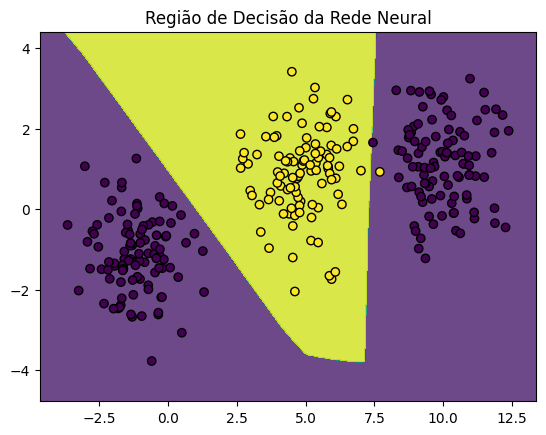

In [21]:
# Prever a classe para cada ponto na grade
grid = np.c_[xx.ravel(), yy.ravel()].T
Z = prever(grid, best_params)
Z = Z.reshape(xx.shape)

# Plotar a região de decisão
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[0, :], X[1, :], c=Y.ravel(), edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Região de Decisão da Rede Neural")
plt.show()